# Preprocessing
\
The raw data are point clouds generated by MLS (mobile LiDAR). The very first preprocessing step involves processing by the SLAM algorithm (more specifically, via the application provided by GeoSLAM), and unzip files.

Then, the next part consists in classifying ground points, generating a DTM, and extracting vegetation points in a slice parallel to DTM. This step is carried out using the opensource software Computree, and is detailed in the file computree_steps.xsct2 (it is ready to use, only the input files need to be selected and the output folder specified, parameters can also be viewed and modified).

Note: depending on the device you are using, it may be necessary to tile the point cloud before processing with Computree. In this case, make sure you convert to point format 7 and merge the output tile files before moving on. I recommend using CloudCompare for tiling and for converting .laz to .las.

*Output folder: 'computree_outputs'*

# Clustering
\
*Input folder: 'computree_outputs'*

In [ ]:
# Loading packages and modules
import os
import glob
from clustering import ClEngine, Cluster

las_files_path = 'computree_outputs' # location of preprocessed files
clustered_files_path = 'cluster_outputs' # location of clustered files

# Listing all .las files to cluster
las_files = glob.glob('computree_outputs/*.las')
print(las_files)

# Listing clustered files
clustered = glob.glob('cluster_outputs/*.las')
clustered_names = [os.path.splitext(os.path.basename(file))[0] for file in clustered]

In [ ]:
for file in las_files:
    
    # Checking if the file is not already clustered
    if os.path.splitext(os.path.basename(file))[0]+'_clusters' not in clustered_names:
        
        cl = ClEngine(file)
        
        # Cluster .las file points
        cl.DBSCAN_clustering(eps=0.05, min_samples=100) # distance parameters are in meters
        
        # Filter clusters given on a minimum number of points and minimum length. Note that filter based on
        # a minimum length take a long to process, set the min_dist param to "None" if you don't want to
        # use it.
        cl.filtering(nb_points=500, min_dist=None)
        
        # Draw a (very) basic representation of the clusters
        # cl.draw_clusters()
        
        # Save clustering results in new .las files (filename_clusters.las)
        cl.save_clusters()

*Output folder: 'cluster_outputs'*

# Cylinder fitting
\
A RANSAC cylinder fitting operation must be carried out. Here, it is carried out in CloudCompare, with the following parameters:  

    - Minimum support points per primitive: 500 or 1000 (depending on general point
    density of the .las file)
    - Use Least Squares fitting on found shapes
    - Attempt to simplify shapes
    - Set random color for each shape found
    - Looking for cylinder primitives  
    
    Parameters
    - Max distance to primitive: e = 0.1m
    - Sampling resolution: b = 0.02
    - Max normal deviation: a = 25.00°
    - Overlooking probability: 0.0001  
    
    Cylinder advanced parameters
    - Min radius: 0.03m
    - Max radius: 0.5m  
    
This step is also a visual validation step. Do not hesitate to change a few settings.

The point clouds of detected cylindrical shapes (not mesh !) must be exported in cloud ascii format (.txt), with headers as column titles. Make sure you save the multiple point clouds of the same study area in the same sub-folder.  

*Output folders: 'shapes_raw/sub-folders'*

# Image classification
\
## Image creation
\
First, we need to create images from the previously generated points clouds of cylindrical shapes. Graphs are generated from the points by colouring them according to their z coordinate, and are exported in .png format.

*Input folder: 'shapes_raw'*

In [ ]:
# Loading packages and modules
import os
import glob
import image_creation as imgcreate

# Path of folder with folders containing the files from which to create images
path_raw = 'shapes_raw'

# Image sizing
image_size_inches = (4, 4) # in inches
dpi = 75

In [ ]:
# Browse all files and create images from each file
for folder in glob.glob(path_raw+'/*'):
    
    folder_name = os.path.splitext(os.path.basename(folder))[0]
    dest = dataset_path + '/' + folder_name
    
    imgcreate.image_generator(data_folder=folder, img_folder=dest, figsize=image_size_inches, dpi=dpi)

## NNCLR model
\
The aim is not to spend our time manually classifying images, so we will be using a NNCLR model, adapted to a small labelled training set. The NNCLR model used here is based on the example of https://keras.io/examples/vision/nnclr/ (see link for more details).

*Input folder: 'NNCLR_data', must contain a 'labelled' folder with image sub-folders for each class, and an 'unlabelled' image folder for training*

In [1]:
import os
import tensorflow as tf
import image_classification as imgclf

device = 'CPU:0' # device used to run tensorflow
model_path = 'NNCLR_data' # path with all image folders, including labelled and unlabelled images for training
batch_size = 32
num_epochs = 50 # max number of epochs, the model will stop automatically when val_p_loss has not increased for 5 epochs
image_size = (231, 231) # in pixels

Found 636 files belonging to 2 classes.
Using 509 files for training.
Found 636 files belonging to 2 classes.
Using 127 files for validation.
Found 905 files belonging to 1 classes.
Epoch 1/50
31/31 [==============================] - 99s 3s/step - c_loss: 3.4022 - c_acc: 0.1946 - r_acc: 0.0309 - p_loss: 10.0455 - p_acc: 0.0000e+00 - val_p_loss: 24.4090 - val_p_acc: 0.0000e+00
Epoch 2/50
31/31 [==============================] - 102s 3s/step - c_loss: 3.3033 - c_acc: 0.1813 - r_acc: 0.0389 - p_loss: 6.7403 - p_acc: 0.2054 - val_p_loss: 5.5106 - val_p_acc: 0.9062
Epoch 3/50
31/31 [==============================] - 105s 3s/step - c_loss: 3.2994 - c_acc: 0.2345 - r_acc: 0.0529 - p_loss: 5.9124 - p_acc: 0.8622 - val_p_loss: 14.1628 - val_p_acc: 0.2188
Epoch 4/50
31/31 [==============================] - 106s 3s/step - c_loss: 3.1093 - c_acc: 0.2471 - r_acc: 0.0553 - p_loss: 3.3751 - p_acc: 0.6853 - val_p_loss: 3.7158 - val_p_acc: 0.9375
Epoch 5/50
31/31 [==============================] - 109s

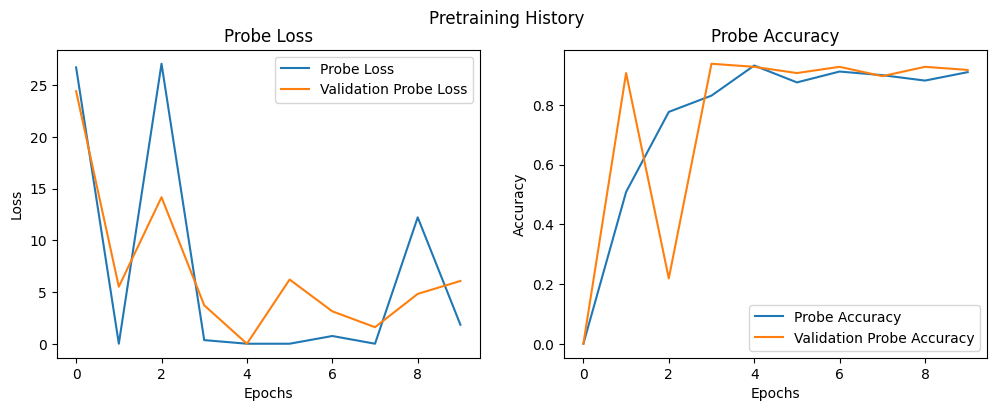

Epoch 1/50
31/31 [==============================] - 44s 1s/step - loss: 5.9603 - acc: 0.8730 - val_loss: 1.2620 - val_acc: 0.9062
Epoch 2/50
31/31 [==============================] - 43s 1s/step - loss: 0.3894 - acc: 0.9113 - val_loss: 0.2884 - val_acc: 0.9375
Epoch 3/50
31/31 [==============================] - 42s 1s/step - loss: 0.2101 - acc: 0.9214 - val_loss: 0.3158 - val_acc: 0.9062
Epoch 4/50
31/31 [==============================] - 40s 1s/step - loss: 0.2287 - acc: 0.9294 - val_loss: 0.2662 - val_acc: 0.8958
Epoch 5/50
31/31 [==============================] - 38s 1s/step - loss: 0.1906 - acc: 0.9315 - val_loss: 0.3020 - val_acc: 0.9167
Epoch 6/50
31/31 [==============================] - 37s 1s/step - loss: 0.1590 - acc: 0.9355 - val_loss: 0.4433 - val_acc: 0.9062
Epoch 7/50
31/31 [==============================] - 37s 1s/step - loss: 0.2077 - acc: 0.9335 - val_loss: 0.3468 - val_acc: 0.9062
Epoch 8/50
31/31 [==============================] - 36s 1s/step - loss: 0.1864 - acc: 0.93

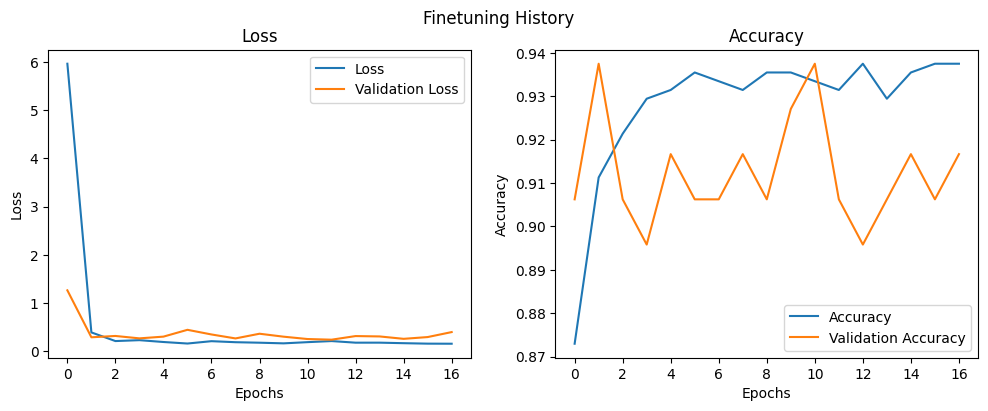

In [2]:
with tf.device(device):
    
    # Initialise model hyperparameters. For information:
    # input_shape = (image_size[0], image_size[1], 3)
    # AUTOTUNE = tf.data.AUTOTUNE
    # shuffle_buffer = 5000   
    # temperature = 0.1
    # queue_size = 10000
    # contrastive_augmenter = {
    #     "brightness": 0.5,
    #     "name": "contrastive_augmenter",
    #     "scale": (0.2, 1.0)}
    # classification_augmenter = {
    #     "brightness": 0.2,
    #     "name": "classification_augmenter",
    #     "scale": (0.5, 1.0)}
    # width = 128
    model = imgclf.Model(model_path, image_size, batch_size, num_epochs)
    
    # Prepare training and validation datasets
    model.prepare_dataset()
    
    # Pre-train NNCLR
    model.pretraining()
    
    # Evaluate the model
    model.finetuning()    
    
    # Save model weights
    model.save_weights()